# 3D Gaussian Splatting for Real-Time Radiance Field Rendering (SIGGRAPH 2023)

arXiv - https://arxiv.org/abs/2308.04079

## 0. What is 3D Gaussian Splatting?

In page 4 of the paper,

> *We Choose 3D Gaussians, which are differentiable and can be easily projected to 2D Splats allowing fast alpha-blending or rendering.*

## 1. Preprocess the Dataset

### 1.1 Download the NeRF-synthetic Dataset

> The paper uses 3 datasets, NeRF-synthetic dataset, Mip-NeRF 360 dataset, and Tanks&Templates dataset.

We will start with NeRF-synthetic dataset that are easy to access.

In [16]:
from pathlib import Path
import gdown

# Setup dataset folder
dataset_path = Path("datasets/")

# Check if the dataset folder exists, and if not, download the dataset.
if dataset_path.is_dir():
  print(f"[INFO] {dataset_path} already exists.")
else:
  print(f"[INFO] Cannot find {dataset_path}, creating the directory...")
  dataset_path.mkdir(parents=True, exist_ok=True)

[INFO] datasets already exists.


In [3]:
!gdown "https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g" -O "./datasets/nerf_synthetic.zip"

Downloading...
From (original): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g
From (redirected): https://drive.google.com/uc?id=1OsiBs2udl32-1CqTXCitmov4NQCYdA9g&confirm=t&uuid=1ccac145-9bec-4eb8-b806-4542f08a901a
To: /content/datasets/nerf_synthetic.zip
100% 1.27G/1.27G [00:09<00:00, 130MB/s]


In [7]:
import zipfile

# Unzip NeRF_Synthetic dataset
with zipfile.ZipFile(dataset_path / "nerf_synthetic.zip", "r") as zip_ref:
  print("[INFO] Unzipping nerf_synthetic dataset...")
  zip_ref.extractall(dataset_path)

# Delete existing compressed dataset file
!rm "./datasets/nerf_synthetic.zip"

[INFO] Unzipping nerf_synthetic dataset...


### 1.2 Explore the NeRF-synthetic dataset

Stats:
+ 8 Scenes -  ***(chair, drums, ficus, hotdog, lego, materials, mic, ship)***
+ 100 Training images
+ 100 Validation images
+ 200 Test images
+ Images are 800x800

Structure:
  * SCENE_NAME
    * train
      * r_num.png
    * val
      * r_num.png
    * test
      * r_num.png
      * r_num_depth_0000.png
      * r_num_normal_0000.png
    * transforms_train.json
    * transforms_val.json
    * transforms_test.json

Transform json details:
  * camera_angle_x: The FOV in x dimension
  * frames: List of dictionaries that contain the camera transform matrices for each image.

Random image path: datasets/nerf_synthetic/ship/train/r_7.png
Image Height * Width : 800 * 800


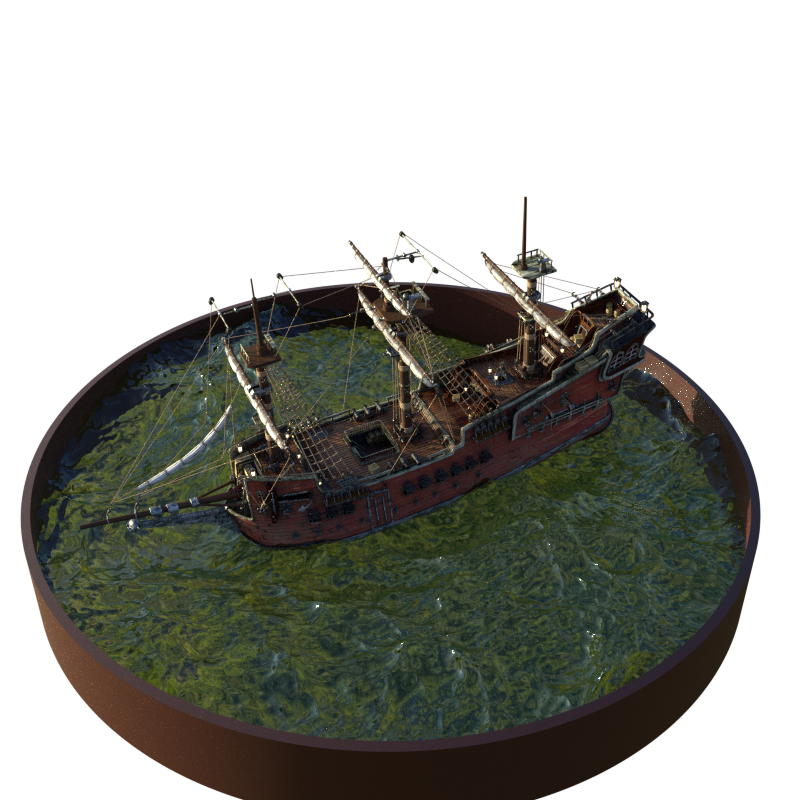

In [24]:
import random
from PIL import Image

# Get All Image Paths
nerf_synthetic_path = dataset_path / "nerf_synthetic"
image_path_list = list(nerf_synthetic_path.glob("*/*/*.png"))

# Get Random Image Path
random_image_path = random.choice(image_path_list)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Height * Width : {img.height} * {img.width}")
img

### 1.3 Make SfM (Structure-from-Motion) points from NeRF-synthetic dataset



In [25]:
!pip install pycolmap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 10.9 MB/s eta 0:00:00


In [26]:
!pip install enlighten

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.7 MB/s eta 0:00:00


In [39]:
from typing import List
from pathlib import Path
import pycolmap
from pycolmap import logging
import shutil
import enlighten

def make_SfM_points(dataset_path_list: List[Path]):
  """
  Args:
    dataset_path_list: List[str] -
  Returns:

  """
  output_path = Path("COLMAP/")
  database_path = output_path / "database.db"
  sfm_path = output_path / "sfm"

  output_path.mkdir(parents=True, exist_ok=True)
  logging.set_log_destination(logging.INFO, output_path / "logs")

  if database_path.exists():
    database_path.unlink()

  for dataset_path in dataset_path_list:
    pycolmap.extract_features(database_path, dataset_path)
    pycolmap.match_exhaustive(database_path)
  num_images = pycolmap.Database(database_path).num_images

  if sfm_path.exists():
    shutil.rmtree(sfm_path)
  sfm_path.mkdir(exist_ok=True)

  with enlighten.Manager() as manager:
    with manager.counter(total=num_images, desc="Image registered:") as pbar:
      pbar.udpate(0, force=True)
      records = pycolmap.incremental_mapping(
          database_path,
          dataset_path_list,
          sfm_path,
          initial_image_pair_callback=lambda: pbar.update(2),
          next_image_callback=lambda: pbar.update(1),
      )

  for idx, record in records.items():
    logging.info(f"#{idx} {record.summary}")

In [40]:
dataset_path_list = [image for image in image_path_list if "train" in image.parts]
len(dataset_path_list)

800

In [41]:
make_SfM_points(dataset_path_list)

TypeError: extract_features(): incompatible function arguments. The following argument types are supported:
    1. (database_path: str, image_path: str, image_list: list[str] = [], camera_mode: pycolmap._core.CameraMode = <CameraMode.AUTO: 0>, camera_model: str = 'SIMPLE_RADIAL', reader_options: pycolmap._core.ImageReaderOptions = ImageReaderOptions(), sift_options: pycolmap._core.SiftExtractionOptions = SiftExtractionOptions(), device: pycolmap._core.Device = <Device.auto: -1>) -> None

Invoked with: PosixPath('COLMAP/database.db'); kwargs: imgae_list=[PosixPath('datasets/nerf_synthetic/chair/train/r_37.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_9.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_83.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_30.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_38.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_23.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_28.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_51.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_97.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_10.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_7.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_44.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_63.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_99.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_95.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_76.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_48.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_80.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_85.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_34.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_40.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_36.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_81.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_2.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_31.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_89.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_46.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_45.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_50.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_87.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_90.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_82.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_77.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_96.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_66.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_70.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_47.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_15.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_29.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_42.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_71.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_18.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_43.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_84.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_41.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_59.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_91.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_75.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_32.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_52.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_1.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_49.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_56.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_78.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_27.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_69.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_86.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_67.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_94.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_73.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_13.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_92.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_88.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_64.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_20.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_11.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_22.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_98.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_19.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_14.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_12.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_62.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_57.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_16.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_53.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_8.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_21.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_74.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_0.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_54.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_3.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_25.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_39.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_24.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_4.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_60.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_79.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_55.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_65.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_68.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_33.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_61.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_93.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_26.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_35.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_58.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_6.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_72.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_5.png'), PosixPath('datasets/nerf_synthetic/chair/train/r_17.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_37.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_9.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_83.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_30.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_38.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_23.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_28.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_51.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_97.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_10.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_7.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_44.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_63.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_99.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_95.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_76.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_48.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_80.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_85.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_34.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_40.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_36.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_81.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_2.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_31.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_89.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_46.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_45.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_50.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_87.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_90.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_82.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_77.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_96.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_66.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_70.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_47.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_15.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_29.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_42.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_71.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_18.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_43.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_84.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_41.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_59.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_91.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_75.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_32.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_52.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_1.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_49.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_56.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_78.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_27.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_69.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_86.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_67.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_94.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_73.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_13.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_92.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_88.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_64.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_20.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_11.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_22.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_98.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_19.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_14.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_12.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_62.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_57.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_16.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_53.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_8.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_21.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_74.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_0.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_54.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_3.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_25.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_39.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_24.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_4.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_60.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_79.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_55.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_65.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_68.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_33.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_61.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_93.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_26.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_35.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_58.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_6.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_72.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_5.png'), PosixPath('datasets/nerf_synthetic/lego/train/r_17.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_37.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_9.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_83.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_30.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_38.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_23.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_28.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_51.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_97.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_10.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_7.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_44.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_63.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_99.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_95.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_76.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_48.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_80.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_85.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_34.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_40.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_36.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_81.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_2.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_31.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_89.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_46.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_45.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_50.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_87.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_90.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_82.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_77.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_96.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_66.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_70.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_47.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_15.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_29.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_42.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_71.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_18.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_43.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_84.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_41.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_59.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_91.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_75.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_32.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_52.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_1.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_49.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_56.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_78.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_27.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_69.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_86.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_67.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_94.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_73.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_13.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_92.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_88.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_64.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_20.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_11.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_22.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_98.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_19.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_14.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_12.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_62.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_57.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_16.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_53.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_8.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_21.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_74.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_0.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_54.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_3.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_25.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_39.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_24.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_4.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_60.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_79.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_55.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_65.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_68.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_33.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_61.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_93.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_26.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_35.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_58.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_6.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_72.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_5.png'), PosixPath('datasets/nerf_synthetic/mic/train/r_17.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_37.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_9.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_83.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_30.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_38.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_23.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_28.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_51.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_97.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_10.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_7.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_44.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_63.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_99.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_95.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_76.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_48.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_80.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_85.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_34.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_40.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_36.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_81.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_2.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_31.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_89.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_46.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_45.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_50.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_87.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_90.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_82.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_77.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_96.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_66.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_70.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_47.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_15.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_29.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_42.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_71.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_18.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_43.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_84.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_41.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_59.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_91.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_75.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_32.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_52.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_1.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_49.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_56.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_78.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_27.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_69.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_86.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_67.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_94.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_73.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_13.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_92.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_88.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_64.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_20.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_11.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_22.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_98.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_19.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_14.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_12.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_62.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_57.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_16.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_53.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_8.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_21.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_74.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_0.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_54.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_3.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_25.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_39.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_24.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_4.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_60.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_79.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_55.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_65.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_68.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_33.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_61.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_93.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_26.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_35.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_58.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_6.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_72.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_5.png'), PosixPath('datasets/nerf_synthetic/hotdog/train/r_17.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_37.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_9.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_83.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_30.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_38.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_23.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_28.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_51.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_97.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_10.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_7.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_44.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_63.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_99.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_95.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_76.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_48.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_80.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_85.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_34.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_40.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_36.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_81.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_2.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_31.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_89.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_46.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_45.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_50.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_87.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_90.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_82.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_77.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_96.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_66.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_70.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_47.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_15.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_29.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_42.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_71.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_18.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_43.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_84.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_41.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_59.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_91.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_75.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_32.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_52.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_1.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_49.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_56.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_78.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_27.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_69.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_86.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_67.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_94.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_73.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_13.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_92.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_88.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_64.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_20.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_11.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_22.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_98.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_19.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_14.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_12.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_62.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_57.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_16.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_53.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_8.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_21.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_74.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_0.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_54.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_3.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_25.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_39.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_24.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_4.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_60.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_79.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_55.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_65.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_68.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_33.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_61.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_93.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_26.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_35.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_58.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_6.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_72.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_5.png'), PosixPath('datasets/nerf_synthetic/drums/train/r_17.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_37.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_9.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_83.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_30.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_38.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_23.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_28.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_51.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_97.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_10.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_7.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_44.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_63.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_99.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_95.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_76.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_48.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_80.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_85.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_34.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_40.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_36.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_81.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_2.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_31.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_89.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_46.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_45.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_50.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_87.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_90.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_82.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_77.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_96.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_66.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_70.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_47.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_15.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_29.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_42.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_71.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_18.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_43.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_84.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_41.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_59.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_91.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_75.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_32.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_52.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_1.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_49.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_56.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_78.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_27.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_69.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_86.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_67.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_94.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_73.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_13.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_92.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_88.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_64.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_20.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_11.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_22.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_98.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_19.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_14.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_12.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_62.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_57.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_16.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_53.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_8.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_21.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_74.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_0.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_54.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_3.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_25.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_39.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_24.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_4.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_60.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_79.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_55.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_65.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_68.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_33.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_61.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_93.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_26.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_35.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_58.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_6.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_72.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_5.png'), PosixPath('datasets/nerf_synthetic/materials/train/r_17.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_37.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_9.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_83.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_30.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_38.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_23.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_28.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_51.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_97.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_10.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_7.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_44.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_63.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_99.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_95.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_76.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_48.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_80.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_85.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_34.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_40.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_36.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_81.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_2.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_31.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_89.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_46.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_45.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_50.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_87.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_90.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_82.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_77.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_96.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_66.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_70.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_47.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_15.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_29.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_42.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_71.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_18.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_43.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_84.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_41.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_59.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_91.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_75.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_32.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_52.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_1.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_49.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_56.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_78.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_27.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_69.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_86.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_67.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_94.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_73.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_13.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_92.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_88.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_64.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_20.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_11.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_22.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_98.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_19.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_14.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_12.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_62.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_57.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_16.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_53.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_8.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_21.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_74.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_0.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_54.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_3.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_25.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_39.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_24.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_4.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_60.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_79.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_55.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_65.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_68.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_33.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_61.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_93.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_26.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_35.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_58.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_6.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_72.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_5.png'), PosixPath('datasets/nerf_synthetic/ficus/train/r_17.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_37.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_9.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_83.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_30.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_38.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_23.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_28.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_51.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_97.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_10.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_7.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_44.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_63.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_99.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_95.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_76.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_48.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_80.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_85.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_34.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_40.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_36.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_81.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_2.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_31.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_89.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_46.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_45.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_50.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_87.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_90.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_82.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_77.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_96.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_66.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_70.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_47.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_15.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_29.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_42.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_71.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_18.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_43.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_84.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_41.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_59.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_91.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_75.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_32.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_52.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_1.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_49.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_56.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_78.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_27.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_69.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_86.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_67.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_94.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_73.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_13.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_92.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_88.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_64.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_20.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_11.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_22.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_98.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_19.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_14.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_12.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_62.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_57.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_16.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_53.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_8.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_21.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_74.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_0.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_54.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_3.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_25.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_39.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_24.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_4.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_60.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_79.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_55.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_65.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_68.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_33.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_61.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_93.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_26.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_35.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_58.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_6.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_72.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_5.png'), PosixPath('datasets/nerf_synthetic/ship/train/r_17.png')]

## References

https://xoft.tistory.com/44

https://xoft.tistory.com/51